In [1]:
import pandas as pd
import requests
import io

CH_HOST = 'http://localhost:8123'
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

def get_clickhouse_data(query, host = CH_HOST, connection_timeout = 1500):
    r = requests.post(host, params = {'query': query}, timeout = connection_timeout)
    if r.status_code == 200:
        return r.text
    else:
        raise ValueError(r.text)
        
def get_clickhouse_df(query, host = CH_HOST, connection_timeout = 1500):
    data = get_clickhouse_data(query, host, connection_timeout) 
    df = pd.read_csv(io.StringIO(data), sep = '\t')
    return df

def upload(table, content, host=CH_HOST):
    content = content.encode('utf-8')
    query_dict = {
             'query': 'INSERT INTO ' + table + ' FORMAT TabSeparatedWithNames '
        }
    r = requests.post(host, data=content, params=query_dict)
    result = r.text
    if r.status_code == 200:
        return result
    else:
        raise ValueError(r.text)

In [3]:
import numpy as np  
prev = np.array([0.7, 0.2, 0.1])
curr = np.array([0.6, 0.27, 0.13])

def get_kl_divergence(prev, curr):
    kl = prev * np.log(prev / curr)
    return np.sum(kl)

def get_js_divergence(prev, curr): 
    mean = (prev + curr)/2
    return 0.5*(get_kl_divergence(prev, mean) + get_kl_divergence(curr, mean))

def get_l1(prev, curr):
    return np.abs(prev - curr).sum()/2

kl = get_kl_divergence(prev, curr)
js = get_js_divergence(prev, curr)

print('KL divergence = %.4f, JS divergence = %.4f' % (get_kl_divergence(prev, curr), get_js_divergence(prev, curr)))

KL divergence = 0.0216, JS divergence = 0.0055


### Simulations

In [4]:
q = '''
with browsers as (
    SELECT
    UserAgent,
    count() AS raw_sessions,
    100. * count() / (
        SELECT count()
        FROM datasets.visits_v1
        FINAL
    ) AS raw_sessions_share
    FROM datasets.visits_v1
    FINAL
    GROUP BY 1
)
select
    if(raw_sessions_share >= 5, UserAgent, 0) as browser,
    sum(raw_sessions) as sessions
from browsers
group by browser
order by sessions desc
format TSVWithNames
'''

base_df = get_clickhouse_df(q)

In [5]:
base_df = base_df.set_index('browser')

In [6]:
base_df

,sessions
browser,
7,493225
0,274107
2,236929
3,235439
4,196628
120,154012
50,86381


In [7]:
def calculate_metrics(sim_df):
    sim_df['share'] = sim_df.sessions/sim_df.sessions.sum()
    sim_df['sim_share'] = sim_df.sim_sessions/sim_df.sim_sessions.sum()
    l1 = get_l1(sim_df.share, sim_df.sim_share)
    kl = get_kl_divergence(sim_df.share, sim_df.sim_share)
    js = get_js_divergence(sim_df.share, sim_df.sim_share)
    return {'l1 norm': l1, 'kl divergence': kl, 'js divergence': js}

def simulate_data_loss(base_df, lost_browser_id, lost_share):
    sim_df = base_df.copy()
    sim_df['sim_sessions'] = sim_df.sessions
    
    lost_traffic = int(round(lost_share*sim_df.sessions.loc[lost_browser_id]))
    sim_df['sim_sessions'].loc[lost_browser_id] = sim_df['sim_sessions'].loc[lost_browser_id] - lost_traffic
    
    traffic_effect_size = lost_traffic / sim_df.sessions.sum()
    metrics = calculate_metrics(sim_df)
    metrics['effect_size_share'] = traffic_effect_size
    metrics['effect_size'] = lost_traffic
    metrics['lost_share'] = lost_share
    metrics['lost_browser'] = lost_browser_id
    return metrics

def simulate_data_changes(base_df, from_browser_id, to_browser_id, change_share):
    sim_df = base_df.copy()
    sim_df['sim_sessions'] = sim_df.sessions
    
    change_traffic = int(round(change_share*sim_df.sessions.loc[from_browser_id]))
    sim_df['sim_sessions'].loc[from_browser_id] = sim_df['sim_sessions'].loc[from_browser_id] - change_traffic
    sim_df['sim_sessions'].loc[to_browser_id] = sim_df['sim_sessions'].loc[to_browser_id] + change_traffic
    
    traffic_effect_size = change_traffic / sim_df.sessions.sum()
    metrics = calculate_metrics(sim_df)
    metrics['effect_size_share'] = traffic_effect_size
    metrics['effect_size'] = change_traffic
    metrics['from_browser'] = from_browser_id
    metrics['to_browser'] = to_browser_id
    return metrics

In [8]:
effect_sizes = np.linspace(0, 0.99, 100)
effect_sizes

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

In [9]:
data_loss_metrics = []

for lost_browser_id in base_df.index:
    for effect_size in effect_sizes:
        data_loss_metrics.append(
            simulate_data_loss(base_df, lost_browser_id, effect_size)
        )
        
data_loss_metrics_df = pd.DataFrame(data_loss_metrics)

In [10]:
data_change_metrics = []

for from_browser in base_df.index:
    for to_browser in base_df.index:
        if from_browser == to_browser:
            continue
        for effect_size in effect_sizes:
            data_change_metrics.append(
                simulate_data_changes(base_df, from_browser, to_browser, effect_size)
            )
            
data_change_metrics_df = pd.DataFrame(data_change_metrics)

In [40]:
data_loss_metrics_df['actual effect'] = data_loss_metrics_df.effect_size_share
data_change_metrics_df['actual effect'] = data_change_metrics_df.effect_size_share

### Visualisations

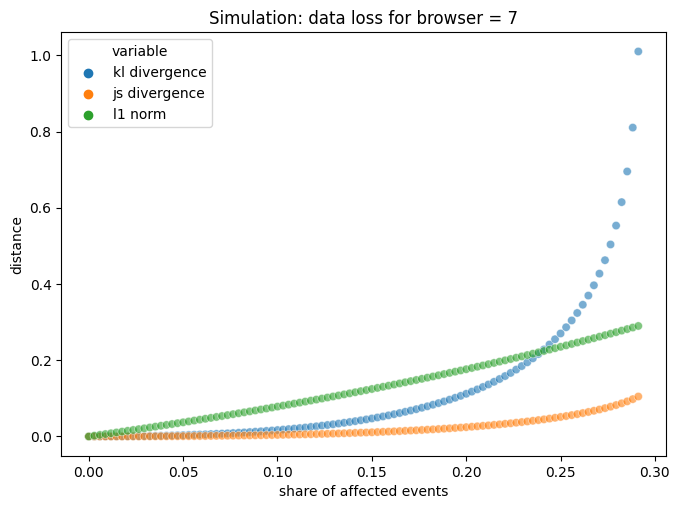

In [32]:
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 7.8, 5.5

def make_distances_plot(plot_df, title):
    ax = sns.scatterplot(x = 'effect_size_share', y = 'value', hue = 'variable',
             data = pd.melt(plot_df[['kl divergence', 'js divergence', 'l1 norm', 'effect_size_share']], 
                            ['effect_size_share']), alpha = 0.6)

    ax.set_xlabel('share of affected events')
    ax.set_ylabel('distance')
    ax.set_title(title)
    
make_distances_plot(data_loss_metrics_df[data_loss_metrics_df.lost_browser == 7], 
                    'Simulation: data loss for browser = 7')

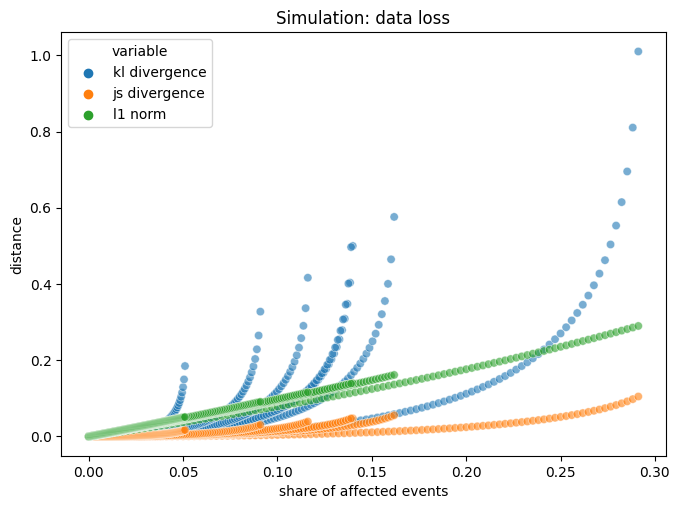

In [33]:
make_distances_plot(data_loss_metrics_df, 
                    'Simulation: data loss')

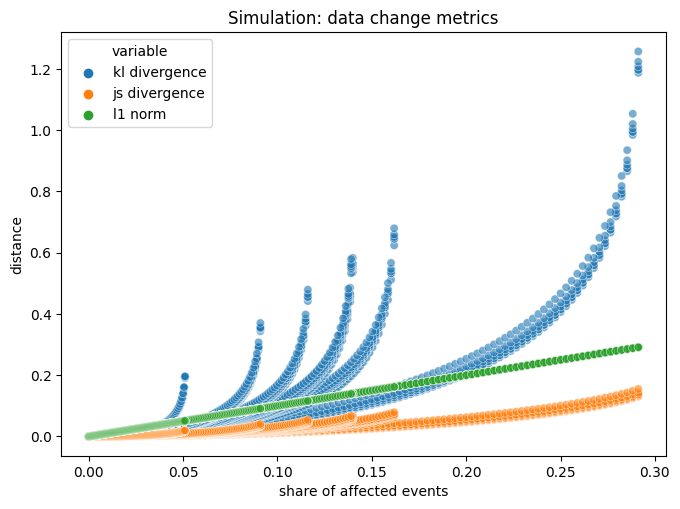

In [34]:
make_distances_plot(data_change_metrics_df, 
                    'Simulation: data change metrics')

In [35]:
data_loss_metrics_df['lost_browser_fmt'] = data_loss_metrics_df.lost_browser.map(
    lambda x: 'browser = %d' % x
)

In [36]:
def compare_metrics_by_browser(plot_df, distance, group, title):
    ax = sns.scatterplot(x = 'effect_size_share', y = distance, hue = group,
                 data = plot_df, alpha = 0.5)
    
    ax.set_xlabel('share of affected events')
    ax.set_ylabel('distance')
    ax.set_title(title)

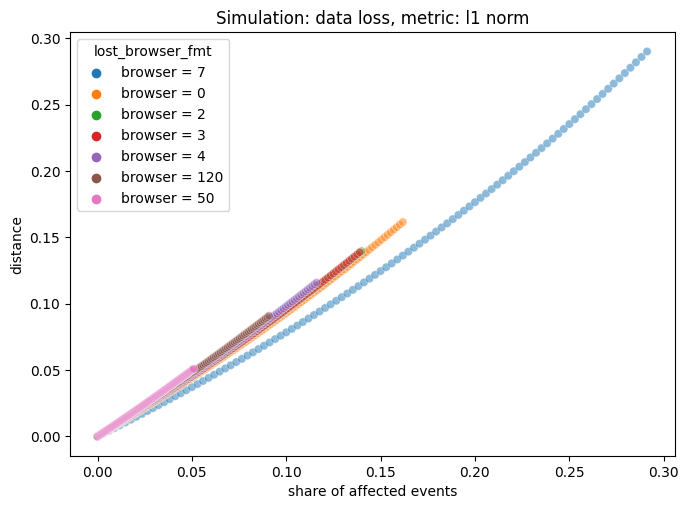

In [37]:
compare_metrics_by_browser(data_loss_metrics_df, 'l1 norm', 'lost_browser_fmt', 
                          'Simulation: data loss, metric: l1 norm')

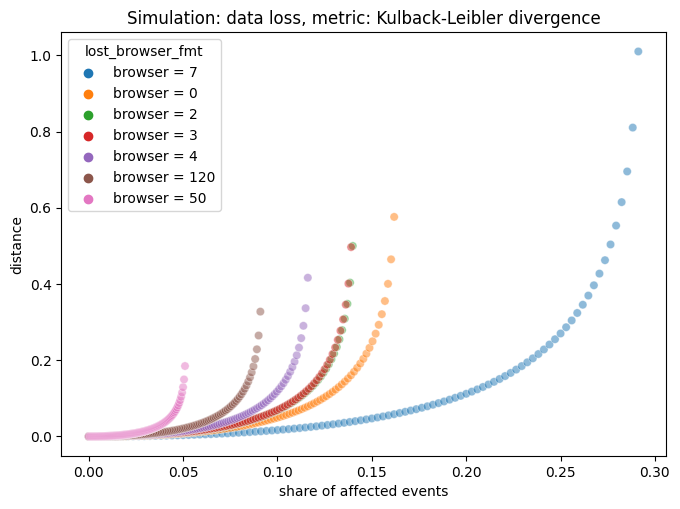

In [38]:
compare_metrics_by_browser(data_loss_metrics_df, 'kl divergence', 'lost_browser_fmt', 
                          'Simulation: data loss, metric: Kulback-Leibler divergence')

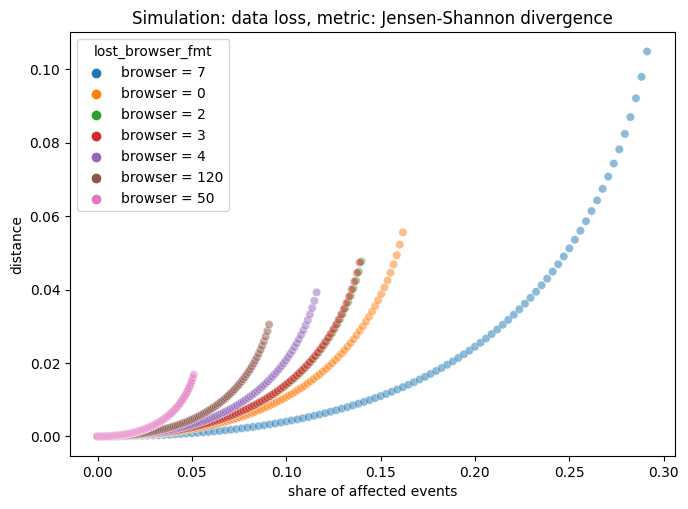

In [39]:
compare_metrics_by_browser(data_loss_metrics_df, 'js divergence', 'lost_browser_fmt', 
                          'Simulation: data loss, metric: Jensen-Shannon divergence')

In [41]:
def make_distances_plot_vs_fact(plot_df, title):
    ax = sns.scatterplot(x = 'effect_size_share', y = 'value', hue = 'variable',
             data = pd.melt(plot_df[['actual effect', 'l1 norm', 'effect_size_share']], 
                            ['effect_size_share']), alpha = 0.6)

    ax.set_xlabel('share of affected events')
    ax.set_ylabel('distance')
    ax.set_title(title)

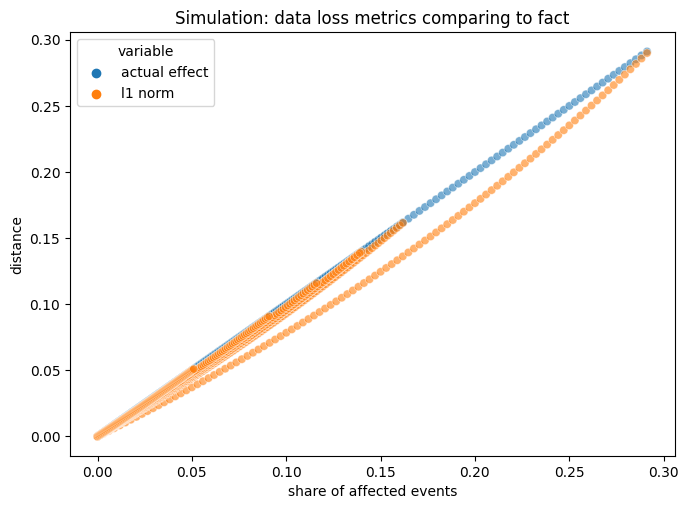

In [45]:
make_distances_plot_vs_fact(data_loss_metrics_df, 
                    'Simulation: data loss metrics comparing to fact')